# afocal window design notebook

This notebook implements window-design calculations for curved-wall vessels, as described in:
"...".

__Import statements:__ do not modify this cell

In [1]:
import windows
import utilities as util  # import print_md, plot_aberrations
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt

## Window design parameters

__Window types to design:__ set variables _True_ to perform design calculations or _False_ to skip calculation:

In [2]:
design_concentric = True
design_singlet = True

__Modify these parameters to match the application for which windows are to be designed:__

_General/universal parameters:_

In [3]:
inner_diameter = 11.53  # cm, inner diameter of curved-wall vessel
window_height = 8.0  # cm
design_wavelength = 530  # nm
window_material = 'fused silica'

n_o = 1.  # refractive index of medium outside vessel
n_i = 1.  # refractive index of medium within vessel

h_f = 1.0  # cm, size of inner retention flats

_Concentric window parameters:_

In [4]:
t_concentric = 2.5  # cm, thickness of the concentric window

_Afocal singlet window parameters:_

In [5]:
t_singlet = 2.5  # cm, thickness of the singlet window

_Cemented doublet window parameters:_

## Concentric window design

Concentric windows consist of a section of an annulus; concentric windows are inherently _not_ afocal.

__Concentric Window as Specified__

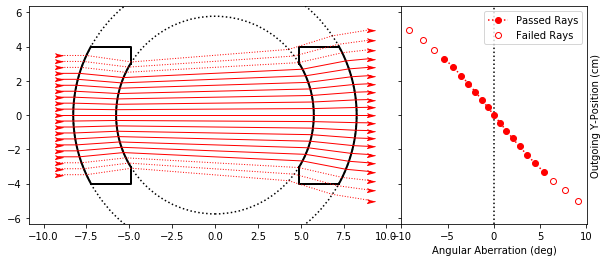

__Concentric Window Aberration vs. Thickness__

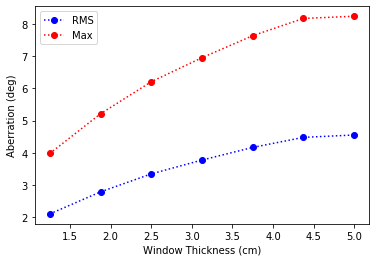

In [6]:
if design_concentric:
    # define concentric window geometry
    Ri = inner_diameter / 2
    Ro = Ri + t_concentric
    h = window_height
    t = t_concentric

    # draw and ray trace the window
    util.print_md('__Concentric Window as Specified__')
    concentric = windows.Concentric(Ri, h, t, h_f, material=window_material, design_wavelength=design_wavelength,
                                    n_o=n_o, n_i=n_i, draw=False, trace=True, draw_rays=False)

    fig, axs = util.ray_aberration_subplots()
    plt.sca(axs[0])
    concentric.draw_annulus(ls=':')
    concentric.draw(new_figure=False)
    plt.ylim(concentric.Ri * np.array([-1.1, 1.1]))
    concentric.draw_rays(sets='success')
    concentric.draw_rays(sets='failed', ls=':')

    plt.sca(axs[1])
    axs[1].yaxis.set_label_position("right")
    util.plot_aberrations(concentric, unit='deg', c='r', new_fig=False,
                          yloc='out', flip_axes=True)
    plt.show()


    util.print_md('__Concentric Window Aberration vs. Thickness__')
    ts = np.linspace(t / 2, 2 * t, 7)
    abb_rms = np.zeros_like(ts)
    abb_max = np.zeros_like(ts)

    for i, t in enumerate(ts):
        draw = False
        concentric._t_1 = t
        concentric.trace_ray_set(n_rays=201, draw=False, inplace=True)
        abb_rms[i] = concentric.rays.rms_aberration(sets='success', unit='deg')
        abb_max[i] = concentric.rays.max_aberration(sets='success', unit='deg')

    plt.figure()
    plt.plot(ts, abb_rms, ':ob', label='RMS')
    plt.plot(ts, abb_max, ':or', label='Max')
    plt.xlabel('Window Thickness (cm)')
    plt.ylabel('Aberration (deg)')
    plt.legend()

## Afocal singlet window design

__Optimization Criteria:__ 'analytical'

Ro = 6.396 cm

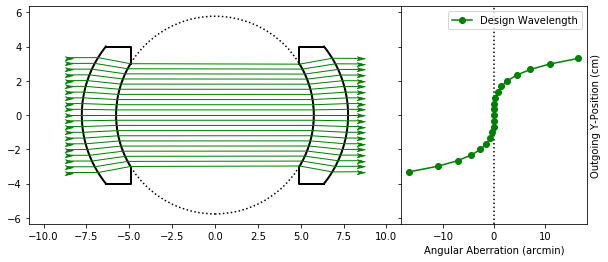

__Optimization Criteria:__ 'rms_aberration'

Ro = 6.428 cm

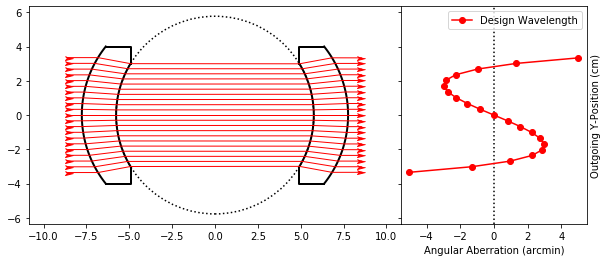

__Optimization Criteria:__ 'max_aberration'

Ro = 6.432 cm

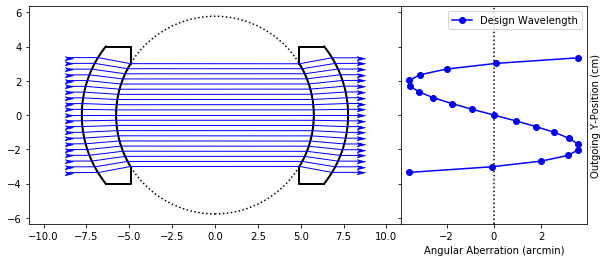

__Comparison of Aberrations by Design Criteria__

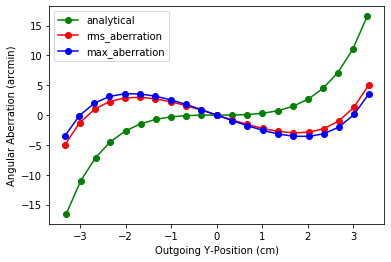

In [8]:
if design_singlet:
    # define concentric window geometry
    Ri = inner_diameter / 2
    h = window_height
    t = 2.0  # t_singlet

    show_chromatic_aberration = False

    singlet = windows.ZeroPowerSinglet(Ri, h, t, h_f=h_f, material=window_material,
                                       design_wavelength=design_wavelength, draw=False,
                                       trace=True, draw_rays=False)

    methods, cs, hs = ['analytical', 'rms_aberration', 'max_aberration'], ['g', 'r', 'b'], []
    for Ro_method, c in zip(methods, cs):

        singlet.optimize_Ro(Ro_method, inplace=True)

        util.print_md(f"__Optimization Criteria:__ '{Ro_method}'")
        util.print_md(f"Ro = {singlet.Ro:4.3f} cm")
        # fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]},
        #                         figsize=(12, 5))
        fig, axs = util.ray_aberration_subplots()

        # draw and ray trace the window
        plt.sca(axs[0])
        singlet.draw(center_circle=True, new_figure=False)
        singlet.draw_rays(c=c)

        plt.sca(axs[1])
        # plt.axhline(ls=':', c='k')
        util.plot_aberrations(singlet, unit='arcmin', c=c, new_fig=False, ls='-', yloc='out', flip_axes=True,
                              failed=False, prefix='Design Wavelength')
        hs += plt.gca().lines[-1:]
        if show_chromatic_aberration:
            util.plot_aberrations(singlet.trace_ray_set(wavelength=400, draw=False), yloc='out', flip_axes=True,
                                  failed=False, new_fig=False, unit='arcmin', c='y', mfc='none', ls='', prefix='400 nm')
            util.plot_aberrations(singlet.trace_ray_set(wavelength=750, draw=False), yloc='out', flip_axes=True,
                                  failed=False, new_fig=False, unit='arcmin', c='m', mfc='none', ls='', prefix='750 nm')

        plt.show()

    util.print_md(f'__Comparison of Aberrations by Design Criteria__')

    plt.figure()
    ax = plt.gcf().add_subplot(111)
    for label, h, c in zip(methods, hs, cs):
        plt.plot(*h.get_data()[::-1], '-o', c=c, label=label)
    plt.legend()
    plt.ylabel(f'Angular Aberration (arcmin)')
    plt.xlabel('Outgoing Y-Position (cm)')